# Support vector machine classifier with $\ell_1$-regularization

In this example we use CVXPY to train a SVM classifier with $\ell_1$-regularization.
We are given data $(x_i,y_i)$, $i=1,\ldots, m$. The $x_i \in {\bf R}^n$ are feature vectors, while the $y_i \in \{\pm 1\}$ are associated boolean outcomes.
Our goal is to construct a good linear classifier $\hat y = {\rm sign}(\beta^T x - v)$.
We find the parameters $\beta,v$ by minimizing the (convex) function

$$
f(\beta,v) = (1/m) \sum_i \left(1 - y_i ( \beta^T x_i-v) \right)_+ + \lambda
\| \beta\|_1
$$

The first term is the average hinge loss. The second term shrinks the coefficients in $\beta$ and encourages sparsity.
The scalar $\lambda \geq 0$ is a (regularization) parameter.
Minimizing $f(\beta,v)$  simultaneously selects features and fits the classifier.

## Example

In the following code we *generate data* with $n=20$ features by randomly choosing $x_i$ and a sparse $\beta_{\mathrm{true}} \in {\bf R}^n$.
We then set $y_i = {\rm sign}(\beta_{\mathrm{true}}^T x_i -v_{\mathrm{true}} - z_i)$, where the $z_i$ are i.i.d. normal random variables.
We divide the data into training and test sets with $m=1000$ examples each.

In [239]:
# Generate data for SVM classifier with L1 regularization.
import numpy as np

np.random.seed(1)
n = 20
m = 1000
TEST = m
DENSITY = 0.2
beta_true = np.random.randn(n, 1) # shape n x 1
idxs = np.random.choice(a = range(n), size = int((1 - DENSITY) * n), replace=False)
# 80% of the features are zero
for idx in idxs:
    beta_true[idx] = 0
offset = 0
sigma = 45

In [240]:
X = np.random.normal(loc = 0, scale = 5, size=(m, n)) # m data x n features
Y = np.sign(X.dot(beta_true) + offset + np.random.normal(loc = 0, scale = sigma, size=(m, 1)))  # m data x 1 response
X_test = np.random.normal(loc = 0, scale = 5, size=(TEST, n))
Y_test = np.sign(
    X_test.dot(beta_true) + offset + np.random.normal(loc = 0, scale = sigma, size=(TEST, 1))
)

We next formulate the optimization problem using CVXPY.

In [241]:
# Form SVM with L1 regularization problem.
import cvxpy as cp

beta = cp.Variable((n, 1))  # n x 1
v = cp.Variable()
loss = cp.sum(cp.pos(1 - cp.multiply(Y, X @ beta - v)))
reg = cp.norm(beta, 1)
lambd = cp.Parameter(nonneg=True)
# symbolic representations of constants
prob = cp.Problem(cp.Minimize(loss / m + lambd * reg))

We solve the optimization problem for a range of $\lambda$ to compute a trade-off curve.
We then plot the train and test error over the trade-off curve.
A reasonable choice of $\lambda$ is the value that minimizes the test error.

In [242]:
# Compute a trade-off curve and record train and test error.
TRIALS = 100
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)
lambda_vals = np.logspace(-2, 0, TRIALS)
beta_vals = []
for i in range(TRIALS):
    lambd.value = lambda_vals[i]
    prob.solve()
    train_error[i] = (
        np.sign(X.dot(beta_true) + offset) != np.sign(X.dot(beta.value) - v.value)
    ).sum() / m
    test_error[i] = (
        np.sign(X_test.dot(beta_true) + offset)
        != np.sign(X_test.dot(beta.value) - v.value)
    ).sum() / TEST
    beta_vals.append(beta.value)

/Users/peterhu/Documents/Learning/Math/Self-Learning/Optimization/Stanford-cvx101_ConvexOp/.venv/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


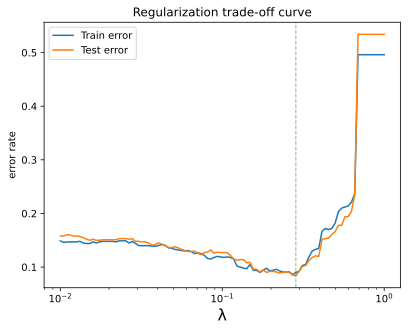

In [252]:
# Plot the train and test error over the trade-off curve.
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
best_lambd = np.argmin(test_error)
plt.xscale("log")
plt.legend(loc="upper left")
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel("error rate")
# plot a vertical line at the optimal lambda
plt.axvline(lambda_vals[best_lambd], linestyle="--", color="g", lw=1, alpha=0.5)
plt.title("Regularization trade-off curve")
plt.show()

We also plot the regularization path, or the $\beta_i$ versus $\lambda$. Notice that the $\beta_i$ do not necessarily decrease monotonically as $\lambda$ increases.
4 features remain non-zero longer for larger $\lambda$ then the rest, which suggests that these features are the most important. In fact $\beta_{\mathrm{true}}$ had 4 non-zero values.

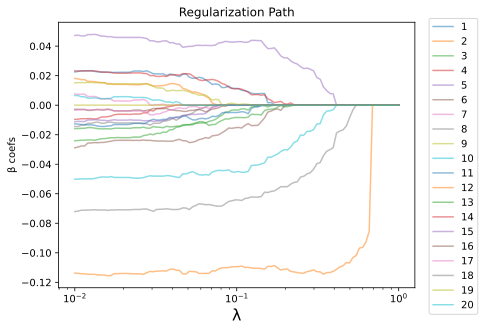

In [253]:
# Plot the regularization path for beta.
for i in range(n):
    plt.plot(lambda_vals, [wi[i, 0] for wi in beta_vals], label="{}".format(i + 1), alpha=0.5)
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel(r"$\beta$ coefs")
plt.title("Regularization Path")
plt.legend(loc=(1.04, -0.1))
plt.xscale("log")
plt.show()


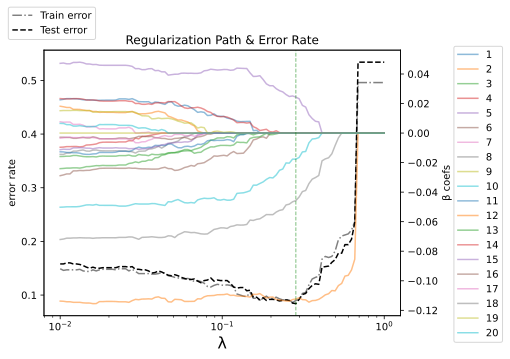

In [255]:
# Plot the regularization path for beta.
fig, ax1 = plt.subplots()
plt.plot(lambda_vals, train_error, label="Train error", linestyle='-.', color= 'grey')
plt.plot(lambda_vals, test_error, label="Test error", linestyle='dashed', color= 'black')
plt.xscale("log")
plt.legend(loc=(-0.1, 1.04))
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel("error rate")

params = {'mathtext.default': 'regular' }         
ax2 = ax1.twinx()
for i in range(n):
    plt.plot(lambda_vals, [wi[i, 0] for wi in beta_vals], label="{}".format(i+1), alpha=0.5)
plt.axvline(lambda_vals[best_lambd], linestyle="--", color="g", lw=1, alpha=0.5)
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel(r"$\beta$ coefs")
plt.title("Regularization Path & Error Rate")
plt.legend(loc=(1.15, -0.1))
plt.xscale("log")
plt.show()
